In [173]:
import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize 
from string import punctuation
from nltk.corpus import stopwords
import nltk
import ssl
from time import time
from textblob import TextBlob
# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context
nltk.download('vader_lexicon')
nltk.download('punkt')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import numpy as np
import pandas as pd
from pprint import pprint
from sklearn.linear_model import Ridge
import seaborn as sns

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score,classification_report
from datetime import datetime

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nikhilagrawal/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nikhilagrawal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [174]:
reviews_filename = 'final_english_reviews.csv'
users_filename = 'Users_ON.csv'
restaurants_filename = 'Restuarants_ON.csv'

def prepareData(reviews_filename,users_filename,restaurants_filename,nrows):
    reviewData = pd.read_csv(reviews_filename).sample(nrows,random_state = 42)
    userData = pd.read_csv(users_filename)
    restaurantData = pd.read_csv(restaurants_filename)
    restaurantData = restaurantData.loc[restaurantData['business_id'].isin(reviewData['business_id'])]
    userData = userData.loc[userData['user_id'].isin(reviewData['user_id'])]
   
    return reviewData,userData,restaurantData

In [175]:
reviewData,userData,restaurantData = prepareData(reviews_filename,users_filename,restaurants_filename,30000)

In [176]:
reviewData.head()

,user_id,review_id,text,business_id,stars,date
165612,4D6LLuJfao_eHGA6XZR-bA,H-XFlahPoAKFSeIyOOt-nw,Found myself a hidden gem thanks to my friend'...,CB8HrynUWR4Odnj-XTY-Ew,5,2015-11-30
129588,A-IkCqnYosZa49XD9qiSww,ah2pO_Q7sA99AvLF1xLeiw,Overpriced for what you're getting. There are ...,djqiu4L7P2sF1JY0DP7UHQ,2,2013-12-30
91326,2e5V6M4GNufEnbGJpVdCjw,RxgjLLnW8aHucq-M8omejQ,Tried the curry goat and oxtail with rice and...,WGmeYEd6Kd3rHWVMO2IM6A,3,2014-07-13
25414,eKD0oCdjDxwn0IN6552oyQ,4JFNkGeK2Pyfkmz35pMUCw,I Absolutely Love this place! I spent four yea...,-av1lZI1JDY_RZN2eTMnWg,4,2013-10-01
9570,BRyMkJp6ge2dvoxWUUJYcw,ZIyb9AkK0wXeUuiABOimSw,Cora's is a great place to go if you desire a ...,cpR25rH3tdth2oiM9a_07g,4,2016-05-03


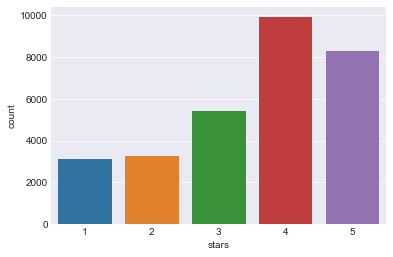

In [177]:
sns.set_style('darkgrid')
sns.countplot(x='stars',data=reviewData)


In [178]:
def getSentimentScore(reviewData):
    sid = SentimentIntensityAnalyzer()
    pos = []
    neg = []
    for text in reviewData['text']:
        score = sid.polarity_scores(text)
        pos.append(score['pos'])
        neg.append(score['neg'])
    reviewData['PostiveScore'] = pos
    reviewData['NegativeScore'] = neg
    return reviewData

In [179]:
reviewData = getSentimentScore(reviewData)

In [180]:
def filterLen(docs, minlen):
    r""" filter out terms that are too short. 
    docs is a list of lists, each inner list is a document represented as a list of words
    minlen is the minimum length of the word to keep
    """
    return [ [t for t in d if len(t) >= minlen ] for d in docs ]

def remove_stop_words(docs):
    en_stops = stopwords.words('english')
    en_stops.extend(['should','they','this','came','would','could'])
    new_docs = []
    for doc in docs:
        new_word = []  
        for word in doc:
            if word not in en_stops:
                new_word.append(word)
        new_docs.append(new_word)
            
    return new_docs

def filterInput(documents):
    new_docs = []
    for doc in documents:
        new_word = []
        for word in doc:
            new_word.append(word.lower())
            for char in word:
                if(not char.isalpha()):
                    new_word.remove(word.lower())
                    break
        new_docs.append(new_word)
    
    return new_docs

import re
def remove_punctuation(docs):
    new_docs = []
    for doc in docs:
        new_words = []  
        for word in doc:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
        new_docs.append(new_words)
            
    return new_docs

In [181]:
def preprocessText(reviewData):
    docs =  list(reviewData['text'])
    docs_tokens = [word_tokenize(doc) for doc in docs] 
    docs_filt = filterInput(docs_tokens)
    docs_wo_punctuation = remove_punctuation(docs_filt)
    preprocessed_docs = remove_stop_words(docs_wo_punctuation)
    return preprocessed_docs

In [182]:
pre = preprocessText(reviewData)

In [183]:
def createDictForLDA(preprocessed_docs):
    #Create Corpus
    texts = preprocessed_docs
    # Create Dictionary
    id2word = corpora.Dictionary(preprocessed_docs)
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    return id2word,corpus

In [184]:
id2word,corpus = createDictForLDA(pre)

In [185]:
lda_model = gensim.models.LdaMulticore(workers=3,corpus=corpus,id2word=id2word, num_topics=10, random_state=100,passes=5)

In [186]:
reviewData = getPredictedTopic(reviewData,lda_model,corpus)

In [187]:
def createFeatureDF(reviewData):
    features = pd.DataFrame()
    features['PositiveScore'] = reviewData['PostiveScore']
    features['NegativeScore'] = reviewData['NegativeScore']
    return features

def prepareFeatures(features):
    
    TP1 = []
    TP2 = []
    TP3 = []
    TP4 = []
    TP5 = []
    TP6 = []
    TP7 = []
    TP8 = []
    TP9 = []
    TP10 = []
    TN1 = []
    TN2 = []
    TN3 = []
    TN4 = []
    TN5 = []
    TN6 = []
    TN7 = []
    TN8 = []
    TN9 = []
    TN10 = []
    for j,row in reviewData.iterrows():
        ps = row['PostiveScore']
        ns = row['NegativeScore']
        temp = lda_model.get_topic_terms(row['PredictedTopic'])
        TP1.append(temp[0][1] * ps)
        TP2.append(temp[1][1] * ps)
        TP3.append(temp[2][1] * ps)
        TP4.append(temp[3][1] * ps)
        TP5.append(temp[4][1] * ps)
        TP6.append(temp[5][1] * ps)
        TP7.append(temp[6][1] * ps)
        TP8.append(temp[7][1] * ps)
        TP9.append(temp[8][1] * ps)
        TP10.append(temp[9][1] * ps)
        TN1.append(temp[0][1] * ns)
        TN2.append(temp[1][1] * ns)
        TN3.append(temp[2][1] * ns)
        TN4.append(temp[3][1] * ns)
        TN5.append(temp[4][1] * ns)
        TN6.append(temp[5][1] * ns)
        TN7.append(temp[6][1] * ns)
        TN8.append(temp[7][1] * ns)
        TN9.append(temp[8][1] * ns)
        TN10.append(temp[9][1] * ns)
    features['TP1'] = TP1
    features['TP2'] = TP2
    features['TP3'] = TP3
    features['TP4'] = TP4
    features['TP5'] = TP5
    features['TP6'] = TP6
    features['TP7'] = TP7
    features['TP8'] = TP8
    features['TP9'] = TP9
    features['TP10'] = TP10
    features['TN1'] = TN1
    features['TN2'] = TN2
    features['TN3'] = TN3
    features['TN4'] = TN4
    features['TN5'] = TN5
    features['TN6'] = TN6
    features['TN7'] = TN7
    features['TN8'] = TN8
    features['TN9'] = TN9
    features['TN10'] = TN10

In [188]:
features = createFeatureDF(reviewData)
prepareFeatures(features)
features.head()

,PositiveScore,NegativeScore,TP1,TP2,TP3,TP4,TP5,TP6,TP7,TP8,...,TN1,TN2,TN3,TN4,TN5,TN6,TN7,TN8,TN9,TN10
165612,0.195,0.008,0.003475,0.002704,0.002195,0.002120,0.001983,0.001558,0.001508,0.001462,...,0.000143,0.000111,0.000090,0.000087,0.000081,0.000064,0.000062,0.000060,0.000056,0.000055
129588,0.089,0.000,0.001911,0.001367,0.001109,0.000944,0.000886,0.000872,0.000687,0.000681,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
91326,0.106,0.000,0.001889,0.001470,0.001193,0.001152,0.001078,0.000847,0.000820,0.000795,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25414,0.245,0.018,0.004808,0.004243,0.003586,0.002486,0.002240,0.002025,0.001910,0.001870,...,0.000353,0.000312,0.000263,0.000183,0.000165,0.000149,0.000140,0.000137,0.000132,0.000126
9570,0.236,0.000,0.004631,0.004087,0.003454,0.002395,0.002158,0.001951,0.001840,0.001802,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [221]:
X = features
y = reviewData['stars']
X_train , X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=42)
clf = Ridge(alpha=1.0)
clf.fit(X_train, y_train) 
pred_rating = clf.predict(X_test)
# print(metrics.mean_absolute_error(y_test,pred_rating))
# print(metrics.mean_squared_error(y_test,pred_rating))

0.7989457958138914
0.9822702524260729


In [222]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha = 0.1)
clf.fit(X_train, y_train)
pred_rating = clf.predict(X_test)
print(metrics.mean_absolute_error(y_test,pred_rating))
print(metrics.mean_squared_error(y_test,pred_rating))

1.0879676825396827
1.6533706334089189


In [223]:
from sklearn.linear_model import LinearRegression
clf = Ridge(alpha=1.0)
clf.fit(X_train, y_train) 
pred_rating = clf.predict(X_test)
print(metrics.mean_absolute_error(y_test,pred_rating))
print(metrics.mean_squared_error(y_test,pred_rating))

0.7989457958138914
0.9822702524260729


In [192]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(max_features=2, min_samples_split=4, n_estimators=50, min_samples_leaf=2)
clf.fit(X_train,y_train)
pred_rating = clf.predict(X_test)
print(metrics.mean_absolute_error(y_test,pred_rating))
print(metrics.mean_squared_error(y_test,pred_rating))

0.7646819231159817
0.9362886384015765


In [214]:
from sklearn.ensemble import ExtraTreesRegressor
clf = ExtraTreesRegressor(max_features=2, min_samples_split=4, n_estimators=50, min_samples_leaf=2,random_state=42)
clf.fit(X_train,y_train)
pred_rating = clf.predict(X_test)
print(metrics.mean_absolute_error(y_test,pred_rating))
print(metrics.mean_squared_error(y_test,pred_rating))

0.7578326686924083
0.9094207162723723


In [194]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0,0.5,'Algorithms')

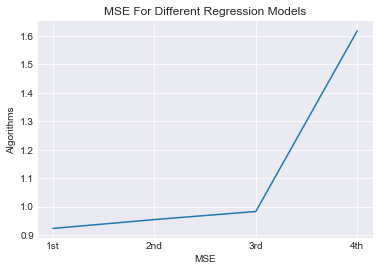

In [195]:
algos = ['1st','2nd','3rd','4th']
accuracies = [0.9234,0.9544,0.9829,1.6174]
plt.plot(algos,accuracies) 
plt.title('MSE For Different Regression Models')
plt.xlabel('MSE')
plt.ylabel('Algorithms')

In [199]:
features.columns

Index(['PositiveScore', 'NegativeScore', 'TP1', 'TP2', 'TP3', 'TP4', 'TP5',
       'TP6', 'TP7', 'TP8', 'TP9', 'TP10', 'TN1', 'TN2', 'TN3', 'TN4', 'TN5',
       'TN6', 'TN7', 'TN8', 'TN9', 'TN10'],
      dtype='object')

In [196]:
features_list = ['PositiveScore','NegativeScore']
fea = features[features_list]
X = fea
y = reviewData['stars']
X_train , X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=42)
clf = Ridge(alpha=1.0)
clf.fit(X_train, y_train) 
pred_rating = clf.predict(X_test)
print(metrics.mean_absolute_error(y_test,pred_rating))
print(metrics.mean_squared_error(y_test,pred_rating))

0.7989773148683932
0.9823212441242863


In [201]:
from sklearn import linear_model
features_list = ['PositiveScore','NegativeScore']
fea = features[features_list]
X = fea
y = reviewData['stars']
X_train , X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=42)
clf = linear_model.Lasso(alpha = 0.1)
clf.fit(X_train, y_train)
pred_rating = clf.predict(X_test)
print(metrics.mean_absolute_error(y_test,pred_rating))
print(metrics.mean_squared_error(y_test,pred_rating))

1.0879676825396827
1.6533706334089189


In [203]:

features_list = ['PositiveScore','NegativeScore']
fea = features[features_list]
X = fea
y = reviewData['stars']
X_train , X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=42)
clf = RandomForestRegressor(max_features=2, min_samples_split=4, n_estimators=50, min_samples_leaf=2)
clf.fit(X_train,y_train)
pred_rating = clf.predict(X_test)
print(metrics.mean_absolute_error(y_test,pred_rating))
print(metrics.mean_squared_error(y_test,pred_rating))

0.7948910813236222
1.018866276292691


In [206]:
features_list = ['PositiveScore','NegativeScore']
fea = features[features_list]
X = fea
y = reviewData['stars']
X_train , X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=42)
clf = ExtraTreesRegressor(max_features=2, min_samples_split=4, n_estimators=50, min_samples_leaf=2,random_state=42)
clf.fit(X_train,y_train)
pred_rating = clf.predict(X_test)
print(metrics.mean_absolute_error(y_test,pred_rating))
print(metrics.mean_squared_error(y_test,pred_rating))

0.7853874188663268
0.989037266778888


# Considering only LDA Word Distribution in topics

In [225]:
features_list = ['TP1', 'TP2', 'TP3', 'TP4', 'TP5',
       'TP6', 'TP7', 'TP8', 'TP9', 'TP10', 'TN1', 'TN2', 'TN3', 'TN4', 'TN5',
       'TN6', 'TN7', 'TN8', 'TN9', 'TN10']
fea = features[features_list]
X = fea
y = reviewData['stars']
X_train , X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=42)
clf = Ridge(alpha=1.0)
clf.fit(X_train, y_train) 
pred_rating = clf.predict(X_test)

print(metrics.mean_squared_error(y_test,pred_rating))

1.4113337188278152


In [226]:
features_list = ['TP1', 'TP2', 'TP3', 'TP4', 'TP5',
       'TP6', 'TP7', 'TP8', 'TP9', 'TP10', 'TN1', 'TN2', 'TN3', 'TN4', 'TN5',
       'TN6', 'TN7', 'TN8', 'TN9', 'TN10']
fea = features[features_list]
X = fea
y = reviewData['stars']
X_train , X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=42)
clf = linear_model.Lasso(alpha = 0.1)
clf.fit(X_train, y_train)
pred_rating = clf.predict(X_test)

print(metrics.mean_squared_error(y_test,pred_rating))

1.6533706334089189


In [218]:
features_list = ['TP1', 'TP2', 'TP3', 'TP4', 'TP5',
       'TP6', 'TP7', 'TP8', 'TP9', 'TP10', 'TN1', 'TN2', 'TN3', 'TN4', 'TN5',
       'TN6', 'TN7', 'TN8', 'TN9', 'TN10']
fea = features[features_list]
X = fea
y = reviewData['stars']
X_train , X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=42)
clf = RandomForestRegressor(max_features=2, min_samples_split=4, n_estimators=50, min_samples_leaf=2)
clf.fit(X_train,y_train)
pred_rating = clf.predict(X_test)

print(metrics.mean_squared_error(y_test,pred_rating))

0.9412243537517659


In [215]:
features_list = ['TP1', 'TP2', 'TP3', 'TP4', 'TP5',
       'TP6', 'TP7', 'TP8', 'TP9', 'TP10', 'TN1', 'TN2', 'TN3', 'TN4', 'TN5',
       'TN6', 'TN7', 'TN8', 'TN9', 'TN10']
fea = features[features_list]
X = fea
y = reviewData['stars']
X_train , X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=42)
clf = ExtraTreesRegressor(max_features=2, min_samples_split=4, n_estimators=50, min_samples_leaf=2,random_state=42)
clf.fit(X_train,y_train)
pred_rating = clf.predict(X_test)

print(metrics.mean_squared_error(y_test,pred_rating))

0.9094207162723723


Text(0,0.5,'Algorithms')

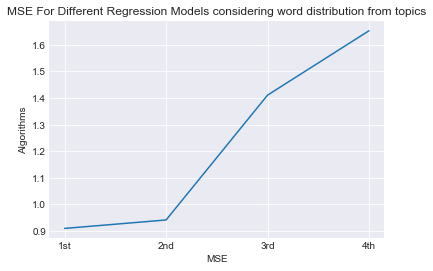

In [220]:
algos = ['1st','2nd','3rd','4th']
accuracies = [0.9094,0.9412,1.411,1.6533]
plt.plot(algos,accuracies) 
plt.title('MSE For Different Regression Models considering word distribution from topics')
plt.xlabel('MSE')
plt.ylabel('Algorithms')

### 1st - ExtraTreesRegressor
### 2nd - 

In [146]:
reviewData = predictRatings(features,reviewData)

In [58]:
year  = []
month = []
for k,row in reviewData.iterrows():
    dateobject = datetime.strptime(row['date'], '%Y-%m-%d')
    year.append(dateobject.year)
    month.append(dateobject.month)
reviewData['year']= year
reviewData['month']= month

In [59]:
def getReviews(q,y):
    if(q == 'quater1'):
        month = [1,2,3]
    elif(q == 'quater2'):
        month = [4,5,6]
    elif(q == 'quater3'):
        month = [7,8,9]
    elif(q == 'quater4'):
        month = [10,11,12]

    temp =  reviewData[(reviewData['year'] == y)]
    return temp[temp['month'].isin(month)]

In [60]:
new_df = getReviews('quater1', 2017)

In [61]:
def getBusinessRatingList(quaterDF):
    business_reviews = defaultdict()
    lis = []
    for i,row in new_df.iterrows():
        a = row['business_id']
        if a not in business_reviews.keys():
            business_reviews[row['business_id']] = lis
        else:
            lis = business_reviews.get(row['business_id'])
        lis.append(row['PredictedRating'])
        business_reviews[row['business_id']] = lis
        lis = []
    # return dictionary key: b_id value: list of ratings
    return business_reviews

In [62]:
business_reviews = getBusinessRatingList(new_df)

In [63]:
final_business_ratings = {}
for val in business_reviews:
    final_business_ratings[val] = np.mean(business_reviews[val])

In [65]:
len(final_business_ratings)

467